# Data Understanding Phase

In [20]:
# Import necessary PySpark modules
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col

In [ ]:
# Create a Spark session
spark = SparkSession.builder.appName('StudentDataAnalysis').getOrCreate()

# Load the CSV file into a PySpark DataFrame
file_path = 'Datasets/student-por.csv'
student_por = spark.read.csv(file_path, header=True, inferSchema=True)

In [5]:
# Display the schema of the DataFrame
student_por.printSchema()

root
 |-- school: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- famsize: string (nullable = true)
 |-- Pstatus: string (nullable = true)
 |-- Medu: integer (nullable = true)
 |-- Fedu: integer (nullable = true)
 |-- Mjob: string (nullable = true)
 |-- Fjob: string (nullable = true)
 |-- reason: string (nullable = true)
 |-- guardian: string (nullable = true)
 |-- traveltime: integer (nullable = true)
 |-- studytime: integer (nullable = true)
 |-- failures: integer (nullable = true)
 |-- schoolsup: string (nullable = true)
 |-- famsup: string (nullable = true)
 |-- paid: string (nullable = true)
 |-- activities: string (nullable = true)
 |-- nursery: string (nullable = true)
 |-- higher: string (nullable = true)
 |-- internet: string (nullable = true)
 |-- romantic: string (nullable = true)
 |-- famrel: integer (nullable = true)
 |-- freetime: integer (nullable = true)
 |-- goout: integer (null

In [6]:
# Display the shape of the DataFrame
print("The shape of the data is: ({0},{1})".format(student_por.count(),len(student_por.columns)))
student_por.limit(5).toPandas()

The shape of the data is: (649,33)


23/10/13 02:11:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


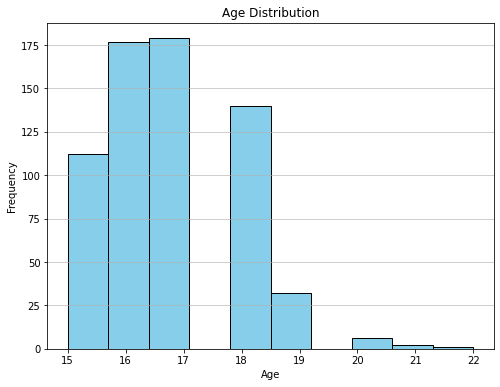

In [7]:
# Collect the 'age' column from the DataFrame and convert it to a list
age_data = student_por.select('age').rdd.flatMap(lambda x: x).collect()

# Create a histogram for the age distribution
plt.figure(figsize=(8, 6))
plt.hist(age_data, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.grid(axis='y', alpha=0.75)
plt.show()


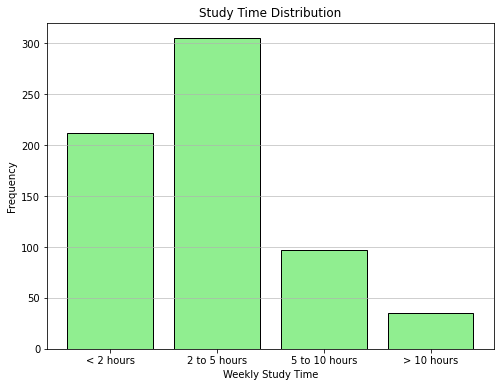

In [8]:
# Create a histogram for the study time distribution
studytime_histogram = student_por.groupBy("studytime").count().orderBy("studytime")
studytime_levels = studytime_histogram.rdd.map(lambda x: x[0]).collect()
studytime_counts = studytime_histogram.rdd.map(lambda x: x[1]).collect()

plt.figure(figsize=(8, 6))
plt.bar(studytime_levels, studytime_counts, color='lightgreen', edgecolor='black')
plt.xlabel('Weekly Study Time')
plt.ylabel('Frequency')
plt.title('Study Time Distribution')
plt.grid(axis='y', alpha=0.75)
plt.xticks(studytime_levels, ['< 2 hours', '2 to 5 hours', '5 to 10 hours', '> 10 hours'])
plt.show()

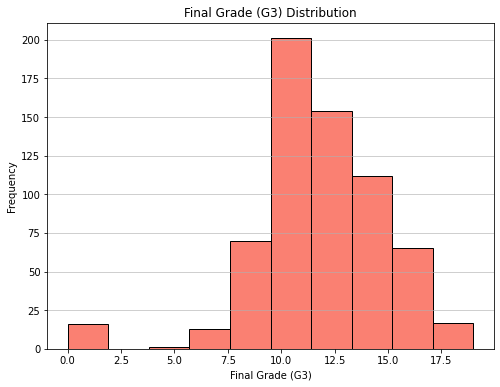

In [9]:
# Collect the 'G3' column from the DataFrame and convert it to a list
final_grade_data = student_por.select('G3').rdd.flatMap(lambda x: x).collect()

# Create a histogram for the final grade (G3) distribution
plt.figure(figsize=(8, 6))
plt.hist(final_grade_data, bins=10, color='salmon', edgecolor='black')
plt.xlabel('Final Grade (G3)')
plt.ylabel('Frequency')
plt.title('Final Grade (G3) Distribution')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [24]:
# Check for missing values
missing_values = student_por.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in student_por.columns])

# Calculate total missing values
total_missing_values = missing_values.agg(*[count(when(col(c) > 0, c)).alias(c) for c in student_por.columns])

# Check completeness
completeness_dict = total_missing_values.first().asDict()
if not any(completeness_dict.values()):
    print("Completeness: Our dataset has no missing entries, ensuring 100% completeness across all fields and records.")
else:
    print("Completeness: There are missing entries in the dataset.")
    print(total_missing_values.show())

# Check for null values
null_counts = student_por.select([count(when(col(c).isNull(), c)).alias(c) for c in student_por.columns])

# Print columns with null values and their respective counts
columns_with_null_values = null_counts.toPandas().melt(var_name='Column', value_name='Missing Count')

if columns_with_null_values['Missing Count'].max() == 0:
    print("No null values found in the dataset.")
else:
    print("Columns with null values:")
    print(columns_with_null_values[columns_with_null_values['Missing Count'] > 0])


Completeness: Our dataset has no missing entries, ensuring 100% completeness across all fields and records.
No null values found in the dataset.


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 44854)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/accumulators.py", line 239, in accum_updates
    num_updates = read_int(se